In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!7z x /content/drive/MyDrive/Classes.zip


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/                                 1 file, 190278912 bytes (182 MiB)

Extracting archive: /content/drive/MyDrive/Classes.zip
 39% 4096 Open              --
Path = /content/drive/MyDrive/Classes.zip
Type = zip
Physical Size = 190278912

  0%      4% 473 - Classes/ No_DR/3832_left.jpeg                                          7% 810 - Classes/ No_DR/6763_right.jpeg                                          10% 1062 - Classes/ No_DR/8907_left.jpeg

In [3]:
# import the libraries
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential


import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pathlib
data_dir = '/content/Classes'
data_dir = pathlib.Path(data_dir)

In [5]:
from pathlib import Path
import imghdr

In [6]:
image_count = len(list(data_dir.glob('*/*.jpeg')))
print(image_count)

10304


In [7]:
batch_size = 32
img_height = 256
img_width = 256

In [8]:
dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    shuffle = True, #to select random image
    image_size = (img_height, img_width),
    batch_size = batch_size)

Found 10304 files belonging to 2 classes.


In [9]:
class_names = dataset.class_names
print(class_names)

[' No_DR', 'DR']


In [10]:
#training images
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.4,
  subset="training",
  seed = 123,
  image_size=(256, 256),
  batch_size= 16)

Found 10304 files belonging to 2 classes.
Using 6183 files for training.


In [15]:
#testing images
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.4,
  subset="validation",
  seed=123,
  image_size=(256, 256),
  batch_size= 16)

Found 10304 files belonging to 2 classes.
Using 4121 files for validation.


In [12]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical", input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.5, seed=None),
    layers.RandomCrop(150, 150, seed=None)
  ]
)

In [13]:
rescale = tf.keras.Sequential([
  layers.Rescaling(1./255)
])

In [16]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [17]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  data_augmentation,
  rescale,
  layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(256,256,3)), 
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [18]:
import time
start_cnn = time.time()

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

path = 'best_model_den.hdf5'
checkpoint = ModelCheckpoint(path, monitor='val_accuracy', verbose = 1, save_best_only = True, mode='max')
es = EarlyStopping(monitor='val_accuracy', patience=10)

callback_list = [checkpoint,es]

In [20]:
model.compile(optimizer='adamax',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=callback_list
)

Epoch 1/50
387/387 [==============================] - ETA: 0s - loss: 0.6970 - accuracy: 0.5036
Epoch 1: val_accuracy improved from -inf to 0.51711, saving model to best_model_den.hdf5
387/387 [==============================] - 271s 673ms/step - loss: 0.6970 - accuracy: 0.5036 - val_loss: 0.6922 - val_accuracy: 0.5171
Epoch 2/50
387/387 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5133
Epoch 2: val_accuracy did not improve from 0.51711
387/387 [==============================] - 228s 588ms/step - loss: 0.6931 - accuracy: 0.5133 - val_loss: 0.6924 - val_accuracy: 0.5157
Epoch 3/50
387/387 [==============================] - ETA: 0s - loss: 0.6925 - accuracy: 0.5214
Epoch 3: val_accuracy improved from 0.51711 to 0.53482, saving model to best_model_den.hdf5
387/387 [==============================] - 227s 588ms/step - loss: 0.6925 - accuracy: 0.5214 - val_loss: 0.6906 - val_accuracy: 0.5348
Epoch 4/50
387/387 [==============================] - ETA: 0s - loss: 0.691

In [22]:
scores = model.evaluate(train_ds)

387/387 [==============================] - 38s 99ms/step - loss: 0.6856 - accuracy: 0.5727


In [23]:
scores = model.evaluate(val_ds)

258/258 [==============================] - 25s 95ms/step - loss: 0.6997 - accuracy: 0.5618


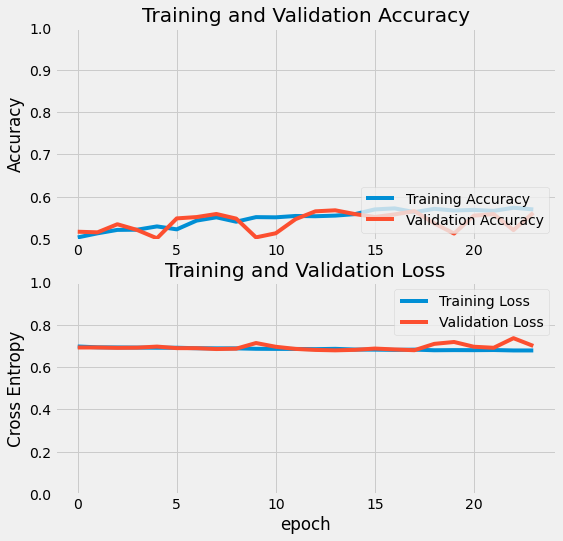

In [24]:
plt.style.use('fivethirtyeight')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [25]:
X = []
y = []
for image,labels in val_ds.take(96):
    for i in image:
        img = i.numpy()
        X.append(img)
    lbl_list = labels.numpy()    
    y.extend(lbl_list) 

In [26]:
x = np.array(X)

In [27]:
y = np.array(y)

In [28]:
x.shape

(1536, 256, 256, 3)

In [29]:
y.shape

(1536,)

In [30]:
from sklearn.metrics import confusion_matrix , classification_report
import numpy as np
y_pred = model.predict(x[:3072])
y_pred_classes = [np.argmax(element) for element in y_pred]
 
print("Classification Report: \n", classification_report(y[:3072], y_pred_classes))

48/48 [==============================] - 12s 224ms/step
Classification Report: 
               precision    recall  f1-score   support

           0       0.53      0.83      0.65       757
           1       0.63      0.29      0.40       779

    accuracy                           0.55      1536
   macro avg       0.58      0.56      0.52      1536
weighted avg       0.58      0.55      0.52      1536

